In [1]:
%load_ext autoreload
%autoreload 2

import utils.utils as utils
import joblib

# --------------------------------------------------------
# Global parameters

# CHANGE TO YOUR DATA LOCATION
data_path = "data"

# The name of the file the computed information will be stored
# data_dict_name = "data_dict_orig_no_cookies"
# our data-dict is located in the root folder with the name 'data_dict_precomputed'
data_dict_name = "data_dict_precomputed"

# has to match the depth that was used in data_collection.py
MAX_DEPTH = 5

# if False the data will be created new if it doesn't exist yet
# the checking can take some time, so setting it to True skips the checking procedure and loads the existing data directly 
LOAD_DATA = True

# If True, the existing data in the data container file will be overwritten (recomputed)
overwrite = False

# Sets the number of characters that are used from each transcript for the classification
# using the full transcript leads to OOM errors, so the value depends on the capacity of the graphics card
max_chars = 2000

# Will be loaded later
LLM = None

In [2]:
# Defining queries that were generated in generate_queries.ipynb
# >> AI generated queries

# critical of immigration
queries_persona_A = [
   "Why immigration is bad for America",
   "How immigrants are taking over our jobs",
   "Why immigration is a threat to our culture",
   "The truth about immigrant criminals",
   "The real reasons why immigrants come to the US",
]

# neutral
queries_persona_C = [
    "Pros and cons of immigration",
    "The impact of immigration on the economy",
    "Immigrant experiences in the UK",
    "Immigration and the NHS",
    "Immigration and education",
]

# supportive
queries_persona_B = [
    "The impact of immigration on the US economy",
    "Immigrant entrepreneurs: success stories and lessons learned",
    "The role of immigration in shaping American culture",
    "Immigration reform: a comprehensive overview",
    "Immigration and the criminal justice system: a critical analysis",
]

# Persona names
personas = ["Persona A", "Persona B", "Persona C"]

# Map persona to queries
persona_queries = {
    "Persona A": queries_persona_A,
    "Persona B": queries_persona_B,
    "Persona C": queries_persona_C,
}

# For plotting
persona_title_dict = {
    "Persona A": "Persona A (critical)", 
    "Persona B": "Persona B (supportive)",
    "Persona C": "Persona C (neutral)"
}

## Data extraction

In [4]:
# load data file or if it doesn't, extract data from the transcripts and store in a dictionary (data_dict_name is the name of this dictionary)

data_dict = utils.load_data(data_dict_name, personas, persona_queries, data_path, overwrite=False, max_depth=MAX_DEPTH)

## Classification

In [5]:
# Load LLM
if LLM is None:
    LLM = utils.load_pipeline(use="mistral")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# Sentiment analysis / classification of the video transcripts using the Mistral LLM

task_name = "Sentiment"

# Prompt we employ to be able to use the LLM as a few shot classifier
prompt_sentiment = """
    First recognize all terms related to immigrants, along with their corresponding sentiment polarity in the given text.
    I want you to determine the sentiment towards immigrants as people from the list of options [critical, neutral, supportive]. 
    Note that if the text criticises the immigration process but not immigrants themselves, the text would be supportive of immigrants.  
    First provide a reasoning (1-2 sentences) for you answer contained in curly brackets: {reasoning} and then, based on your reasoning, 
    also provide your final answer from the options in square brackets like this: [sentiment].
    It is very important that your answer has to match your reasoning and that you adhere to the proper format.
    Do not write anything else. 

    Example 1: 'All immigrants are criminals'
    Answer 1: {reasoning for critical}[critical]

    Example 2: 'No immigrant is illegal'
    Answer 3: {reasoning for supportive}[supportive]

    Example 3: 'Bananas are yellow'
    Answer 3: {reasoning for neutral}[neutral]

    Example 4: 'The immigration process is far too difficult'
    Answer 4: {reasoning for supportive}[supportive]

    Example 5: 'We want to stop this policy that supports immigrants'
    Answer 5: {reasoning for supportive}[critical]
        
"""

possible_values_sentiment = ["critical", "neutral", "supportive"]

if not LOAD_DATA:
    utils.perform_custom_task(LLM, data_dict, personas, prompt_sentiment, task_name, possible_values_sentiment, max_chars=max_chars, verbose=0, overwrite=overwrite)
    joblib.dump(data_dict, data_dict_name)

In [5]:
# Sentiment analysis / classification of the video transcripts using the Mistral LLM

task_name = "Political Orientation"

# Prompt we employ to be able to use the LLM as a few shot classifier
prompt_political_orientation = """
    First recognize all terms related to the political orientation, along with their corresponding sentiment polarity in the given text.
    Determine the political orientation from the list of options [neutral, left, centrist, right], where neutral means the text doesn't have a political orientation, 
    left means the text is politically left, centrist means the text is politically centrist and right means the text is politically right. 

    First provide a reasoning (1-2 sentences) for you answer contained in curly brackets: {reasoning} and then, BASED ON YOUR REASONING, also provide your final answer from the options
    in square brackets like this: [orientation].
    It is very important that your answer has to match your reasoning and that you adhere to the proper format.
    Do not write anything else. 

    Example 1: 'All immigrants are criminals'
    Answer 1: {reasoning for right}[right]

    Example 2: 'No immigrant is illegal'
    Answer 3: {reasoning for left}[left]

    Example 3: 'There are pros and cons to immigration'
    Answer 3: {reasoning for centrist}[centrist]

    Example 4: 'Bananas are yellow'
    Answer 4: {reasoning for neutral}[neutral]
"""

possible_values_political_orientation = ["neutral", "left", "centrist", "right"]

if not LOAD_DATA:
    utils.perform_custom_task(LLM, data_dict, personas, prompt_political_orientation, task_name, possible_values_political_orientation, max_chars=max_chars,  
                            verbose=0, overwrite=overwrite)

    joblib.dump(data_dict, data_dict_name)

## Results

In [7]:
# Define the colors of each category used for plotting
category_color_map = {

    "neutral": "gray",
    "supportive": "blue", 
    "critical": "red",
    
    "left": "blue",
    "right": "red", 
    "centrist": "purple"
}

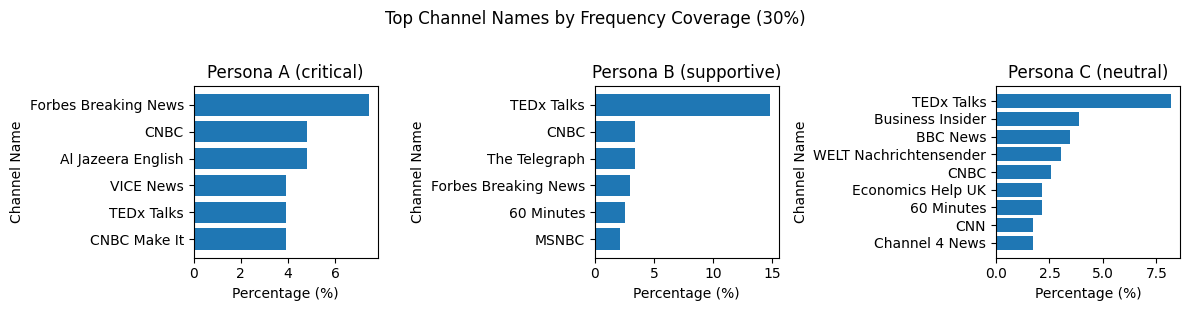

In [8]:
# Plot a histogram of the youtube channel names

utils.plot_histogram(personas, persona_queries, data_dict, persona_title_dict, MAX_DEPTH, "channel_name", threshold=0.3, y_label="Channel Name", only_firsts=False, figsize=(12, 3))

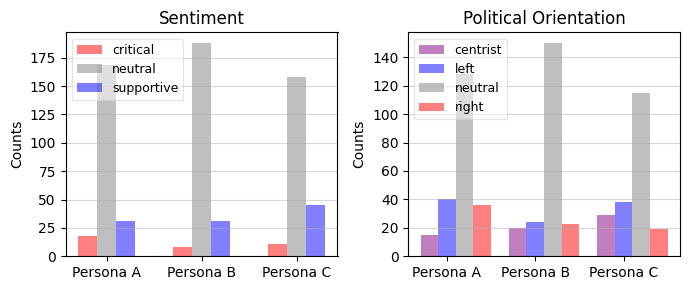

In [10]:
# Plot a histogram of the classification results for each persona

task_names = ["Sentiment", "Political Orientation"]

utils.plot_histogram_per_persona(personas, persona_queries, data_dict, category_color_map, task_names, MAX_DEPTH, figsize=(7,3))

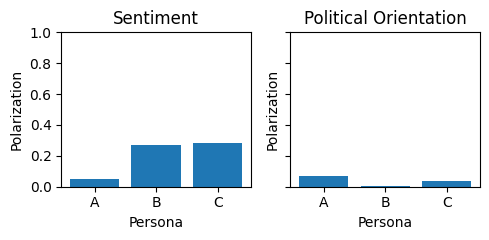

In [9]:
# Plot a barchart of the polarization scores for each persona

task_names = ["Sentiment", "Political Orientation"]

utils.plot_polarization_per_persona(personas, persona_queries, task_names, data_dict, max_depth=MAX_DEPTH, figsize=(5,2.5), include_neutral=False)

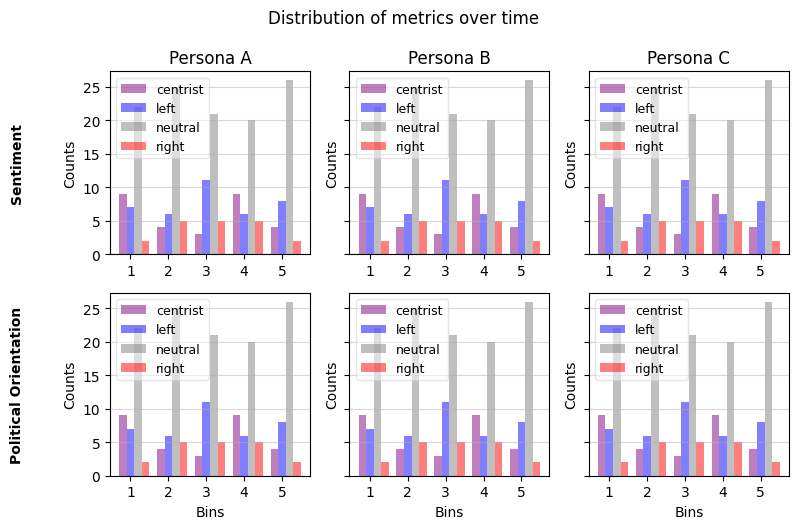

In [11]:
# Plot a histograms of the classification results over time 

task_names = ["Sentiment", "Political Orientation"]

utils.plot_histogram_per_persona_per_bin(personas, persona_queries, data_dict, category_color_map, task_names, max_depth=MAX_DEPTH, figsize=(8, 5))

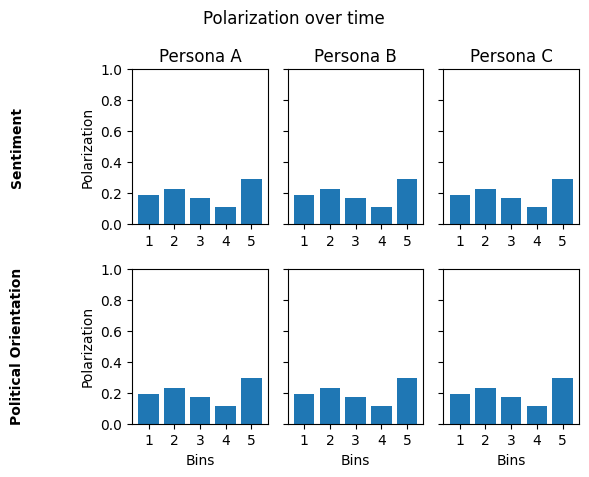

In [14]:
# Plot a barchart with the polarization score corresbonding to the bins in the previous plot 

task_names = ["Sentiment", "Political Orientation"]

utils.plot_histogram_per_persona_per_bin_entropy(personas, persona_queries, data_dict, task_names, max_depth=MAX_DEPTH, figsize=(6, 4.5), include_neutral=False)